In [1]:
%pip install pandas
%pip install pydmd
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install keras_tuner
%pip install keras
%pip install numpy
%pip install optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, platform

base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'

if platform.system() is 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/tf/7zgm_5115vjc9x3162_qjg140000gn/T/ipykernel_18601/1685739801.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if platform.system() is 'Darwin':


In [3]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

Using TensorFlow backend


In [4]:
city = 'muriae'

In [ ]:

def windowing(dataframe, predict_column, step_back, step_front) -> (np.array, np.array):
    dataset = dataframe.values
    dataset_pred = dataframe[predict_column].values

    x, y = [], []
    for i in range(len(dataset) - step_back - step_front):
        j = (i + step_back)
        x.append(dataset[i:j])
        y.append(dataset_pred[j:(j+step_front)])

    return np.array(x), np.array(y)



def split_data(x, y, length, ratio=0.8):
    train_size = int(length * 0.9)
    _train_x, _train_y = x[0:train_size], y[0:train_size].reshape(y[0:train_size].shape[0],)
    _test_x, _test_y = x[train_size:], y[train_size:].reshape(y[train_size:].shape[0],)
    return _train_x, _train_y, _test_x, _test_y


def fill_df(dataframe, filler):
    data = {}
    for column in dataframe.columns:
        data[column] = filler(dataframe[column])
    return pd.DataFrame(data=data, index=dataframe.index.values)


def interpolate_filler(data):
    return data.interpolate(method='linear', limit_direction='backward')


class Scaler:
    scales: {}
    df: DataFrame
    df_scaled: DataFrame
    scaled: bool

    def __init__(self, df: DataFrame, feature_range=(0, 1)):
        self.df = df.copy()
        self.scales = {}
        for c in df.columns:
            self.scales[c] = MinMaxScaler(feature_range=feature_range)
        self.scaled = False

    def get_dataframe_scaled(self):
        if self.scaled:
            return self.df_scaled
        self.scaled = True
        self.df_scaled = self.df.copy()
        for c in self.df.columns:
            self.df_scaled[c] = self.scales[c] \
                .fit_transform(self.df_scaled[c].values.reshape(-1, 1))
        return self.df_scaled


In [5]:
df_temp = pd.read_csv(
    f'{base_path}/data/daily_muriae.csv',
    sep=',',
    parse_dates=['Timestamp'],
    index_col=['Timestamp'])

init_index = lambda _df: _df[_df.RADIATION != 0].index[0]

df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
    .resample('D') \
    .agg({'RADIATION': np.sum, 'TEMP': np.mean, 'HUMIDITY_h': np.mean})

df = df.loc[df.index >= init_index(df)].replace(0, np.nan)
print('Dados faltantes:', df.isna().sum())


df = fill_df(df, interpolate_filler)
print('Dados faltantes:', df.isna().sum())


scaler = Scaler(df)
df = scaler.get_dataframe_scaled()

df

Dados faltantes: RADIATION     131
TEMP          109
HUMIDITY_h    109
dtype: int64
Dados faltantes: RADIATION     0
TEMP          0
HUMIDITY_h    0
dtype: int64


/var/folders/tf/7zgm_5115vjc9x3162_qjg140000gn/T/ipykernel_18601/3653245211.py:9: FutureWarning: The provided callable <function sum at 0x106a91430> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/var/folders/tf/7zgm_5115vjc9x3162_qjg140000gn/T/ipykernel_18601/3653245211.py:9: FutureWarning: The provided callable <function mean at 0x106a958b0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


,RADIATION,TEMP,HUMIDITY_h
2006-08-30,0.446615,0.280066,0.366731
2006-08-31,0.725255,0.179294,0.455319
2006-09-01,0.650863,0.239781,0.477812
2006-09-02,0.067899,0.267965,0.623708
2006-09-03,0.523046,0.427096,0.496049
...,...,...,...
2022-12-27,0.342604,0.452895,0.826748
2022-12-28,0.646377,0.610942,0.691185
2022-12-29,0.480663,0.600970,0.587842
2022-12-30,0.370767,0.460050,0.803040


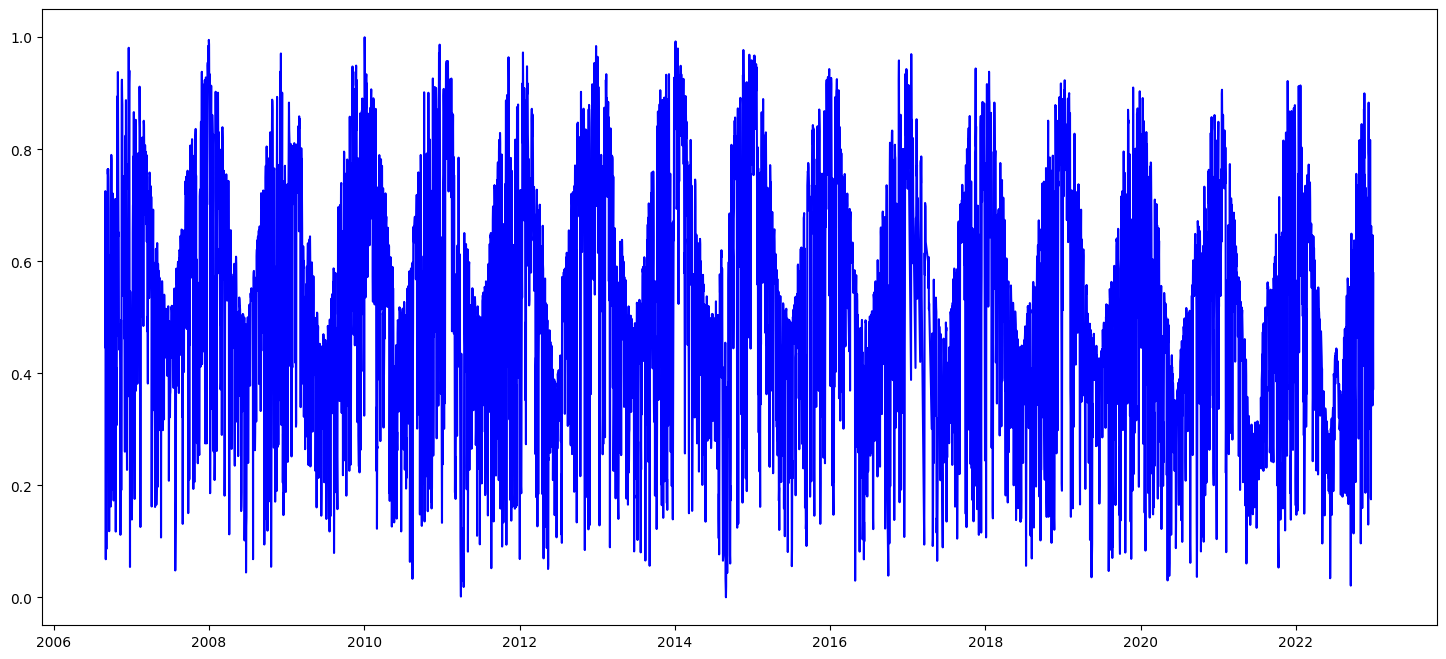

In [6]:
pyplot.figure(figsize=(18,8))

pyplot.plot(df['RADIATION'], color='blue', label='Radiation')

pyplot.show()

In [7]:
X, Y = windowing(df, predict_column='RADIATION', step_back=5, step_front=1)
x_train, y_train, x_test, y_test = split_data(X, Y, length=len(df), ratio=0.9)

In [8]:
print('x', x_train[0])
print('y', y_train[0])

x [[0.44661455 0.28006622 0.36673114]
 [0.72525503 0.17929363 0.45531915]
 [0.65086322 0.23978083 0.47781155]
 [0.0678993  0.26796484 0.62370821]
 [0.5230459  0.42709606 0.49604863]]
y 0.45072035143002115


In [9]:
print(x_train.shape)
print(y_train.shape)

(5371, 5, 3)
(5371,)


In [10]:
def objective(trial):
    n_hidden = trial.suggest_categorical(f"hidden_layers", [0, 1, 2, 3, 5])

    model = keras.Sequential()
    model.add(Dense(units=1, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(
        units=trial.suggest_categorical("lstm_01_unit", [10, 32, 64, 128, 200, 300]),
        return_sequences = n_hidden > 0
        ))
    
    if (trial.suggest_int("enable_dropout_01", 0, 1) == 1):
        model.add(Dropout(
            rate=trial.suggest_categorical("dropout_01_rs", [0, 0.1, 0.25])
        ))

    for i in range(n_hidden):
        model.add(LSTM(
            units=trial.suggest_categorical(f"lstm_{i}_unit", [10, 32, 64, 128, 200, 300]),
            return_sequences = i != (n_hidden-1),
            dropout=trial.suggest_categorical(f"lstm_{i}_drp", [0, 0.1, 0.25])
        ))

    model.add(layers.Dense(1, 
        activation=trial.suggest_categorical("output_activation", ['relu', 'softmax', 'sigmoid'])
    ))
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    print('model output_shape', model.output_shape)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(
        x_train,
        y_train,
        validation_split=trial.suggest_categorical("validation_split", [0.1, 0.2, 0.3]),
        shuffle=True,
        batch_size=trial.suggest_categorical("batch_size", [10, 16, 32, 64]),
        epochs=100,
        verbose=0
    )

    predict = model.predict(x_test)
    y = y_test.reshape(-1,1)
    
    print('Max Y', max(y_test))
    print('Min Y', min(y_test))
    print('Max Pred', max(predict))
    print('Min Pred', min(predict))
    
    mae = mean_absolute_error(y, predict)
    print('MAE SCORE:', mae)
    return mae

In [16]:
n_trials = 4

study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///radiation-forecast.db',
    study_name=f'{city}_interpolate_lstm',
    load_if_exists=True
)

if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=-1
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-09-26 22:16:35,520] A new study created in RDB with name: muriae_interpolate_lstm


model output_shape (None, 1)
model output_shape (None, 1)
model output_shape (None, 1)
model output_shape (None, 1)
19/19 [==============================] - 2s 16ms/step
Max Y 0.9218896039736161
Min Y 0.020886185809277105
Max Pred [0.7969753]
Min Pred [0.2516647]
MAE SCORE: 0.11049489745829523


[I 2023-09-26 22:20:49,541] Trial 0 finished with value: 0.11049489745829523 and parameters: {'hidden_layers': 5, 'lstm_01_unit': 32, 'enable_dropout_01': 0, 'lstm_0_unit': 128, 'lstm_0_drp': 0, 'lstm_1_unit': 10, 'lstm_1_drp': 0, 'lstm_2_unit': 10, 'lstm_2_drp': 0.25, 'lstm_3_unit': 300, 'lstm_3_drp': 0.25, 'lstm_4_unit': 32, 'lstm_4_drp': 0.25, 'output_activation': 'relu', 'learning_rate': 0.0009456180820148659, 'validation_split': 0.1, 'batch_size': 64}. Best is trial 0 with value: 0.11049489745829523.


19/19 [==============================] - 1s 3ms/step


[I 2023-09-26 22:21:38,624] Trial 3 finished with value: 0.11367780297025791 and parameters: {'hidden_layers': 2, 'lstm_01_unit': 32, 'enable_dropout_01': 1, 'dropout_01_rs': 0.1, 'lstm_0_unit': 10, 'lstm_0_drp': 0.25, 'lstm_1_unit': 128, 'lstm_1_drp': 0.25, 'output_activation': 'relu', 'learning_rate': 0.00030414619291172786, 'validation_split': 0.3, 'batch_size': 10}. Best is trial 0 with value: 0.11049489745829523.


Max Y 0.9218896039736161
Min Y 0.020886185809277105
Max Pred [0.8057712]
Min Pred [0.2673991]
MAE SCORE: 0.11367780297025791


KeyboardInterrupt: 